In [2]:
# Bloque 1: Importación de librerías
import pandas as pd
import numpy as np
import re
import string

# Librerías para NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# Descargar recursos de NLTK (solo necesario la primera vez)
nltk.download('punkt')
nltk.download('stopwords')

# Configuración de visualización
pd.set_option('display.max_colwidth', 200)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ferna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ferna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Bloque 2: Cargar el dataset
df = pd.read_csv('tweets_procesados_final.csv')

# Verificar la carga correcta
print(f"Dataset cargado con {len(df)} tweets")
print("\nPrimeras filas del dataset:")
display(df.head())

# Nos enfocaremos en la columna 'Text_Final'
tweets = df['Text_Final'].copy()

Dataset cargado con 3676 tweets

Primeras filas del dataset:


,Tweet_ID,Created_At,Location_Mentioned,tweet_length,Text,Text_Final
0,c3c923bab9a5006041fee2df8da9a2173b2de335f62342eebe05f0208c97e6c1,2024-07-22,Quito,167,Se fue la luz y se dañó el panel electrónico del elevador y el AC. Luma nos está destruyendo y cobrando por hacerlo. Somos muchos los afectados. El desquite va. 👊🏻👊🏻👊🏻,se fue la luz se dañó panel electrónico del elevador ac luma nos está destruyendo cobrando por hacerlo somos muchos los afectados desquite va
1,23cf0973031f6388a6bacb5306160f57e5f23cbdbb597cdb6726ca6e459aa3e5,2024-12-01,Azuay,257,"No quiero arrecharme, pero estos HDP de Corpoelec quitan la luz hoy q hay agua y se puede lavar!!! 😤\n\nCdo hay electricidad, no hay agua \nCdo hay agua, no hay electricidad.\nPónganse d acuerdo n...",no quiero arrecharme pero estos hdp corpoelec quitan la luz hoy hay agua se puede lavar cdo hay electricidad no hay agua cdo hay agua no hay electricidad pónganse acuerdo nojodas tenía desahogarme...
2,33da3cb8621b2ce82a4eb6441dfabf4a059ddde7348fadebdb78a4b11370728a,2024-10-15,Guayaquil,299,"🌌 A dos días del apagón masivo que dejó a medio archipiélago a oscuras, ciudadanos reclamaron esta tarde la salida de LUMA Energy y de Genera PR, los dos operadores privados del sistema eléctrico....",dos días del apagón masivo que dejó medio archipiélago oscuras ciudadanos reclamaron esta tarde la salida luma energy genera pr los dos operadores privados del sistema eléctrico entonando consigna...
3,8ab477a732bec3995a5342dff816b1e903fa41de8e5a491b1278430194904c74,2024-05-14,Guayaquil,177,"A esta hora hay más de 240,000 personas afectadas por otro apagón debido a la incapacidad de LUMA y Genera. No saben, ni pueden administrar el sistema eléctrico. \n\nHasta cuando…",esta hora hay más personas afectadas por otro apagón debido la incapacidad luma genera no saben pueden administrar sistema eléctrico hasta cuando
4,5706da14ade897778baf2a682d451db10fb47965b75d01dc4da1104536c641ec,2024-10-05,Quito,165,La ideología arruina.\n\n‘Red Eléctrica ordena por segundo día consecutivo la paralización de la gran industria ante la falta de electricidad’. https://t.co/pZ4SY05j4k,la ideología arruina red eléctrica ordena por segundo día consecutivo la paralización la gran industria ante la falta electricidad


In [4]:
# Bloque 3: Funciones de preprocesamiento

def limpiar_texto(texto):
    """
    Limpieza básica del texto:
    - Elimina URLs
    - Elimina menciones (@usuario)
    - Elimina caracteres especiales
    - Convierte a minúsculas
    """
    if not isinstance(texto, str):
        return ""
    
    # Eliminar URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    # Eliminar menciones
    texto = re.sub(r'@\w+', '', texto)
    # Eliminar caracteres especiales (conservando palabras con acentos)
    texto = re.sub(r'[^\w\sáéíóúñ]', ' ', texto)
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar números
    texto = re.sub(r'\d+', '', texto)
    # Eliminar espacios múltiples
    texto = re.sub(r'\s+', ' ', texto).strip()
    
    return texto

# Aplicar limpieza
tweets_limpios = tweets.apply(limpiar_texto)

# Verificar resultados
print("\nEjemplo de texto limpio:")
print("Antes:", tweets.iloc[0])
print("Después:", tweets_limpios.iloc[0])


Ejemplo de texto limpio:
Antes: se fue la luz se dañó panel electrónico del elevador ac luma nos está destruyendo cobrando por hacerlo somos muchos los afectados desquite va
Después: se fue la luz se dañó panel electrónico del elevador ac luma nos está destruyendo cobrando por hacerlo somos muchos los afectados desquite va


In [5]:
# Bloque 4 Mejorado: Tokenización y stopwords con manejo de tildes

# Primero necesitamos la función para quitar tildes 
def quitar_tilde(palabra):
    """
    Elimina tildes de palabras en español
    """
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
        ("ü", "u"),
        ("ñ", "n")  # Podemos conservar la ñ o reemplazarla
    )
    for a, b in replacements:
        palabra = palabra.replace(a, b)
    return palabra

# Configurar stopwords personalizadas (las que NO queremos eliminar)
stopwords_excluidas = {'no', 'nada', 'ni', 'me', 'mi', 'mis', 'mi', 'yo', 'tu', 'el'}

# Obtenemos las stopwords básicas del español
stop_words = set(stopwords.words('spanish'))

# Agregamos stopwords comunes en tweets (como en tu guía)
stop_words.update(("q", "xq", "pq", "porq", "x", "d", "i", "pa", "t", "van", "ahi", "ahí"))

# Eliminamos las stopwords excluidas (importantes para análisis de sentimiento)
for palabra in stopwords_excluidas:
    if palabra in stop_words:
        stop_words.remove(palabra)
    # También eliminamos versiones con mayúsculas iniciales
    if palabra.capitalize() in stop_words:
        stop_words.remove(palabra.capitalize())

# Creamos versión sin tildes de las stopwords (como en tu guía)
stop_words_sin_tildes = set()
for palabra in stop_words:
    stop_words_sin_tildes.add(quitar_tilde(palabra))

# Combinamos las stopwords originales y las sin tildes
stop_words_completo = stop_words.union(stop_words_sin_tildes)

def tokenizar_y_filtrar_mejorado(texto):
    """
    Versión mejorada de tokenización y filtrado que:
    1. Tokeniza el texto
    2. Filtra stopwords (incluyendo versiones con/sin tildes)
    3. Elimina signos de puntuación
    4. Filtra tokens muy cortos
    """
    # Tokenización
    tokens = word_tokenize(texto.lower(), language='spanish')
    
    # Filtrado completo
    tokens_filtrados = [
        token for token in tokens 
        if (token not in stop_words_completo and 
            len(token) > 2 and 
            token not in string.punctuation and
            not token.isdigit())
    ]
    
    return tokens_filtrados

# Aplicamos la tokenización mejorada
tweets_tokenizados = tweets_limpios.apply(tokenizar_y_filtrar_mejorado)

# Añadimos columna al dataframe
df['tokens'] = tweets_tokenizados

# Verificación mejorada
print("\nEjemplo completo de tokenización:")
print("Texto original:", tweets.iloc[1])
print("Tokens filtrados:", tweets_tokenizados.iloc[1])


Ejemplo completo de tokenización:
Texto original: no quiero arrecharme pero estos hdp corpoelec quitan la luz hoy hay agua se puede lavar cdo hay electricidad no hay agua cdo hay agua no hay electricidad pónganse acuerdo nojodas tenía desahogarme disculpen sigan lo suyo
Tokens filtrados: ['quiero', 'arrecharme', 'hdp', 'corpoelec', 'quitan', 'luz', 'hoy', 'agua', 'puede', 'lavar', 'cdo', 'electricidad', 'agua', 'cdo', 'agua', 'electricidad', 'pónganse', 'acuerdo', 'nojodas', 'desahogarme', 'disculpen', 'sigan']


In [6]:
# Renombrar la columna 'tokens' a 'tweet_token' para coincidir con tu estructura deseada
df = df.rename(columns={'tokens': 'tweet_token'})

# Mostrar el dataframe con las columnas relevantes
columnas_a_mostrar = ['Tweet_ID', 'Created_At', 'Location_Mentioned', 'tweet_length', 'Text_Final', 'tweet_token']
df_mostrar = df[columnas_a_mostrar].copy()

# Función para mejorar la visualización de los tokens
def formatear_tokens(tokens):
    return ", ".join(f"'{token}'" for token in tokens) if tokens else ""

# Aplicar formato a la columna de tokens para mejor visualización
df_mostrar['tweet_token'] = df_mostrar['tweet_token'].apply(formatear_tokens)

# Mostrar las primeras filas del dataset
print("\nDataset completo con tokens filtrados:")
display(df_mostrar.head())


Dataset completo con tokens filtrados:


,Tweet_ID,Created_At,Location_Mentioned,tweet_length,Text_Final,tweet_token
0,c3c923bab9a5006041fee2df8da9a2173b2de335f62342eebe05f0208c97e6c1,2024-07-22,Quito,167,se fue la luz se dañó panel electrónico del elevador ac luma nos está destruyendo cobrando por hacerlo somos muchos los afectados desquite va,"'luz', 'dañó', 'panel', 'electrónico', 'elevador', 'luma', 'destruyendo', 'cobrando', 'hacerlo', 'afectados', 'desquite'"
1,23cf0973031f6388a6bacb5306160f57e5f23cbdbb597cdb6726ca6e459aa3e5,2024-12-01,Azuay,257,no quiero arrecharme pero estos hdp corpoelec quitan la luz hoy hay agua se puede lavar cdo hay electricidad no hay agua cdo hay agua no hay electricidad pónganse acuerdo nojodas tenía desahogarme...,"'quiero', 'arrecharme', 'hdp', 'corpoelec', 'quitan', 'luz', 'hoy', 'agua', 'puede', 'lavar', 'cdo', 'electricidad', 'agua', 'cdo', 'agua', 'electricidad', 'pónganse', 'acuerdo', 'nojodas', 'desah..."
2,33da3cb8621b2ce82a4eb6441dfabf4a059ddde7348fadebdb78a4b11370728a,2024-10-15,Guayaquil,299,dos días del apagón masivo que dejó medio archipiélago oscuras ciudadanos reclamaron esta tarde la salida luma energy genera pr los dos operadores privados del sistema eléctrico entonando consigna...,"'dos', 'días', 'apagón', 'masivo', 'dejó', 'medio', 'archipiélago', 'oscuras', 'ciudadanos', 'reclamaron', 'tarde', 'salida', 'luma', 'energy', 'genera', 'dos', 'operadores', 'privados', 'sistema'..."
3,8ab477a732bec3995a5342dff816b1e903fa41de8e5a491b1278430194904c74,2024-05-14,Guayaquil,177,esta hora hay más personas afectadas por otro apagón debido la incapacidad luma genera no saben pueden administrar sistema eléctrico hasta cuando,"'hora', 'personas', 'afectadas', 'apagón', 'debido', 'incapacidad', 'luma', 'genera', 'saben', 'pueden', 'administrar', 'sistema', 'eléctrico'"
4,5706da14ade897778baf2a682d451db10fb47965b75d01dc4da1104536c641ec,2024-10-05,Quito,165,la ideología arruina red eléctrica ordena por segundo día consecutivo la paralización la gran industria ante la falta electricidad,"'ideología', 'arruina', 'red', 'eléctrica', 'ordena', 'segundo', 'día', 'consecutivo', 'paralización', 'gran', 'industria', 'falta', 'electricidad'"


In [7]:
# Bloque 5 Corregido: Lematización funcional

# Primero, reinstalemos y verifiquemos Stanza para asegurarnos
!pip install stanza --upgrade
import stanza

# Reiniciamos el pipeline con configuración adecuada
stanza.download('es')  # Solo si no está descargado
nlp = stanza.Pipeline(lang='es', processors='tokenize,lemma', tokenize_pretokenized=True, use_gpu=False)

# Función corregida de lematización
def lematizar_tokens_corregido(tokens):
    if not tokens or len(tokens) == 0:
        return []
    
    # Stanza espera una lista de listas (cada sublista es una oración)
    # Convertimos nuestros tokens en una "oración"
    doc = nlp([tokens])  
    
    lemas = []
    for sentence in doc.sentences:
        for word in sentence.words:
            lemma = word.lemma.lower()
            # Filtramos lemas no deseados y aplicamos limpieza
            if lemma and lemma not in stop_words_completo and len(lemma) > 2:
                lemma_limpio = quitar_tilde(lemma)
                lemas.append(lemma_limpio)
    
    return lemas

# Aplicamos la función corregida
df['tweet_lemma'] = df['tweet_token'].apply(lematizar_tokens_corregido)

# Verificación exhaustiva
print("\nVerificación detallada:")
ejemplo_idx = 1  # El mismo ejemplo que falló
print("Texto original:", df['Text_Final'].iloc[ejemplo_idx])
print("Tokens:", df['tweet_token'].iloc[ejemplo_idx])
print("Lemas:", df['tweet_lemma'].iloc[ejemplo_idx])

2025-05-31 12:38:30 INFO: Downloaded file to C:\Users\ferna\stanza_resources\resources.json
2025-05-31 12:38:30 INFO: Downloading default packages for language: es (Spanish) ...
2025-05-31 12:38:33 INFO: File exists: C:\Users\ferna\stanza_resources\es\default.zip
2025-05-31 12:38:37 INFO: Finished downloading models and saved to C:\Users\ferna\stanza_resources
2025-05-31 12:38:37 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-05-31 12:38:37 INFO: Downloaded file to C:\Users\ferna\stanza_resources\resources.json
2025-05-31 12:38:37 INFO: Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| lemma     | combined_nocharlm |

2025-05-31 12:38:37 INFO: Using device: cpu
2025-05-31 12:38:37 INFO: Loading: tokenize
2025-05-31 12:38:37 INFO: Loading: lemma
2025-05-31 12:38:41 INFO: Done loading processors!



Verificación detallada:
Texto original: no quiero arrecharme pero estos hdp corpoelec quitan la luz hoy hay agua se puede lavar cdo hay electricidad no hay agua cdo hay agua no hay electricidad pónganse acuerdo nojodas tenía desahogarme disculpen sigan lo suyo
Tokens: ['quiero', 'arrecharme', 'hdp', 'corpoelec', 'quitan', 'luz', 'hoy', 'agua', 'puede', 'lavar', 'cdo', 'electricidad', 'agua', 'cdo', 'agua', 'electricidad', 'pónganse', 'acuerdo', 'nojodas', 'desahogarme', 'disculpen', 'sigan']
Lemas: ['querer', 'arrecharme', 'hdp', 'corpoelec', 'quitar', 'luz', 'hoy', 'agua', 'poder', 'lavar', 'cdo', 'electricidad', 'agua', 'cdo', 'agua', 'electricidad', 'ponganse', 'acuerdo', 'nojoda', 'desahogarme', 'disculpar', 'seguir']


In [8]:
# Bloque 7 Mejorado: Visualización del dataset con lematización

# 1. Creamos una copia para visualización manteniendo los datos originales
df_visual = df.copy()

# 2. Creamos columnas formateadas para mejor visualización
df_visual['Tokens'] = df_visual['tweet_token'].apply(lambda tokens: ', '.join([f'"{t}"' for t in tokens]))
df_visual['Lemas'] = df_visual['tweet_lemma'].apply(lambda lemas: ', '.join([f'"{l}"' for l in lemas]))

# 3. Seleccionamos y ordenamos columnas para mostrar
columnas_visualizar = [
    'Tweet_ID',
    'Created_At',
    'Location_Mentioned',
    'Text_Final',
    'Tokens',
    'Lemas'
]

# 4. Configuración de visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.width', 1000)

# 5. Mostramos el dataset con estilo
print("\nDATASET COMPLETO CON TOKENS Y LEMAS")
print("="*80)

# Mostramos 5 ejemplos representativos (3 positivos, 2 negativos si tienes etiquetas)
display(df_visual[columnas_visualizar].head(5).style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}))

# 6. Mostramos estadísticas básicas
print("\nESTADÍSTICAS BASICAS DE LEMATIZACIÓN")
print("="*80)
print(f"Total de tweets procesados: {len(df)}")
print(f"Promedio de tokens por tweet: {df_visual['tweet_token'].apply(len).mean():.1f}")
print(f"Promedio de lemas por tweet: {df_visual['tweet_lemma'].apply(len).mean():.1f}")


DATASET COMPLETO CON TOKENS Y LEMAS


,Tweet_ID,Created_At,Location_Mentioned,Text_Final,Tokens,Lemas
0,c3c923bab9a5006041fee2df8da9a2173b2de335f62342eebe05f0208c97e6c1,2024-07-22,Quito,se fue la luz se dañó panel electrónico del elevador ac luma nos está destruyendo cobrando por hacerlo somos muchos los afectados desquite va,"""luz"", ""dañó"", ""panel"", ""electrónico"", ""elevador"", ""luma"", ""destruyendo"", ""cobrando"", ""hacerlo"", ""afectados"", ""desquite""","""luz"", ""danar"", ""panel"", ""electronico"", ""elevador"", ""luma"", ""destruir"", ""cobrar"", ""hacerlo"", ""afectado"", ""desquite"""
1,23cf0973031f6388a6bacb5306160f57e5f23cbdbb597cdb6726ca6e459aa3e5,2024-12-01,Azuay,no quiero arrecharme pero estos hdp corpoelec quitan la luz hoy hay agua se puede lavar cdo hay electricidad no hay agua cdo hay agua no hay electricidad pónganse acuerdo nojodas tenía desahogarme disculpen sigan lo suyo,"""quiero"", ""arrecharme"", ""hdp"", ""corpoelec"", ""quitan"", ""luz"", ""hoy"", ""agua"", ""puede"", ""lavar"", ""cdo"", ""electricidad"", ""agua"", ""cdo"", ""agua"", ""electricidad"", ""pónganse"", ""acuerdo"", ""nojodas"", ""desahogarme"", ""disculpen"", ""sigan""","""querer"", ""arrecharme"", ""hdp"", ""corpoelec"", ""quitar"", ""luz"", ""hoy"", ""agua"", ""poder"", ""lavar"", ""cdo"", ""electricidad"", ""agua"", ""cdo"", ""agua"", ""electricidad"", ""ponganse"", ""acuerdo"", ""nojoda"", ""desahogarme"", ""disculpar"", ""seguir"""
2,33da3cb8621b2ce82a4eb6441dfabf4a059ddde7348fadebdb78a4b11370728a,2024-10-15,Guayaquil,dos días del apagón masivo que dejó medio archipiélago oscuras ciudadanos reclamaron esta tarde la salida luma energy genera pr los dos operadores privados del sistema eléctrico entonando consignas como con luma patraña los enseres se me dañan,"""dos"", ""días"", ""apagón"", ""masivo"", ""dejó"", ""medio"", ""archipiélago"", ""oscuras"", ""ciudadanos"", ""reclamaron"", ""tarde"", ""salida"", ""luma"", ""energy"", ""genera"", ""dos"", ""operadores"", ""privados"", ""sistema"", ""eléctrico"", ""entonando"", ""consignas"", ""luma"", ""patraña"", ""enseres"", ""dañan""","""dos"", ""dia"", ""apagon"", ""masivo"", ""dejar"", ""medio"", ""archipielago"", ""oscuro"", ""ciudadano"", ""reclamar"", ""tarde"", ""salida"", ""luma"", ""energy"", ""generar"", ""dos"", ""operador"", ""privado"", ""sistema"", ""electrico"", ""entonando"", ""consigna"", ""luma"", ""patrana"", ""enseres"", ""danar"""
3,8ab477a732bec3995a5342dff816b1e903fa41de8e5a491b1278430194904c74,2024-05-14,Guayaquil,esta hora hay más personas afectadas por otro apagón debido la incapacidad luma genera no saben pueden administrar sistema eléctrico hasta cuando,"""hora"", ""personas"", ""afectadas"", ""apagón"", ""debido"", ""incapacidad"", ""luma"", ""genera"", ""saben"", ""pueden"", ""administrar"", ""sistema"", ""eléctrico""","""hora"", ""persona"", ""afectado"", ""apagon"", ""deber"", ""incapacidad"", ""luma"", ""generar"", ""saber"", ""poder"", ""administrar"", ""sistema"", ""electrico"""
4,5706da14ade897778baf2a682d451db10fb47965b75d01dc4da1104536c641ec,2024-10-05,Quito,la ideología arruina red eléctrica ordena por segundo día consecutivo la paralización la gran industria ante la falta electricidad,"""ideología"", ""arruina"", ""red"", ""eléctrica"", ""ordena"", ""segundo"", ""día"", ""consecutivo"", ""paralización"", ""gran"", ""industria"", ""falta"", ""electricidad""","""ideologia"", ""arruinar"", ""red"", ""electrico"", ""ordenar"", ""segundo"", ""dia"", ""consecutivo"", ""paralizacion"", ""gran"", ""industria"", ""falta"", ""electricidad"""



ESTADÍSTICAS BASICAS DE LEMATIZACIÓN
Total de tweets procesados: 3676
Promedio de tokens por tweet: 14.0
Promedio de lemas por tweet: 13.8


In [9]:
# Bloque 8: Nubes de palabras para términos de estrés

# Importar librerías necesarias
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns

# Configuración de estilo
plt.style.use('fivethirtyeight')
plt.rcParams['figure.facecolor'] = 'white'

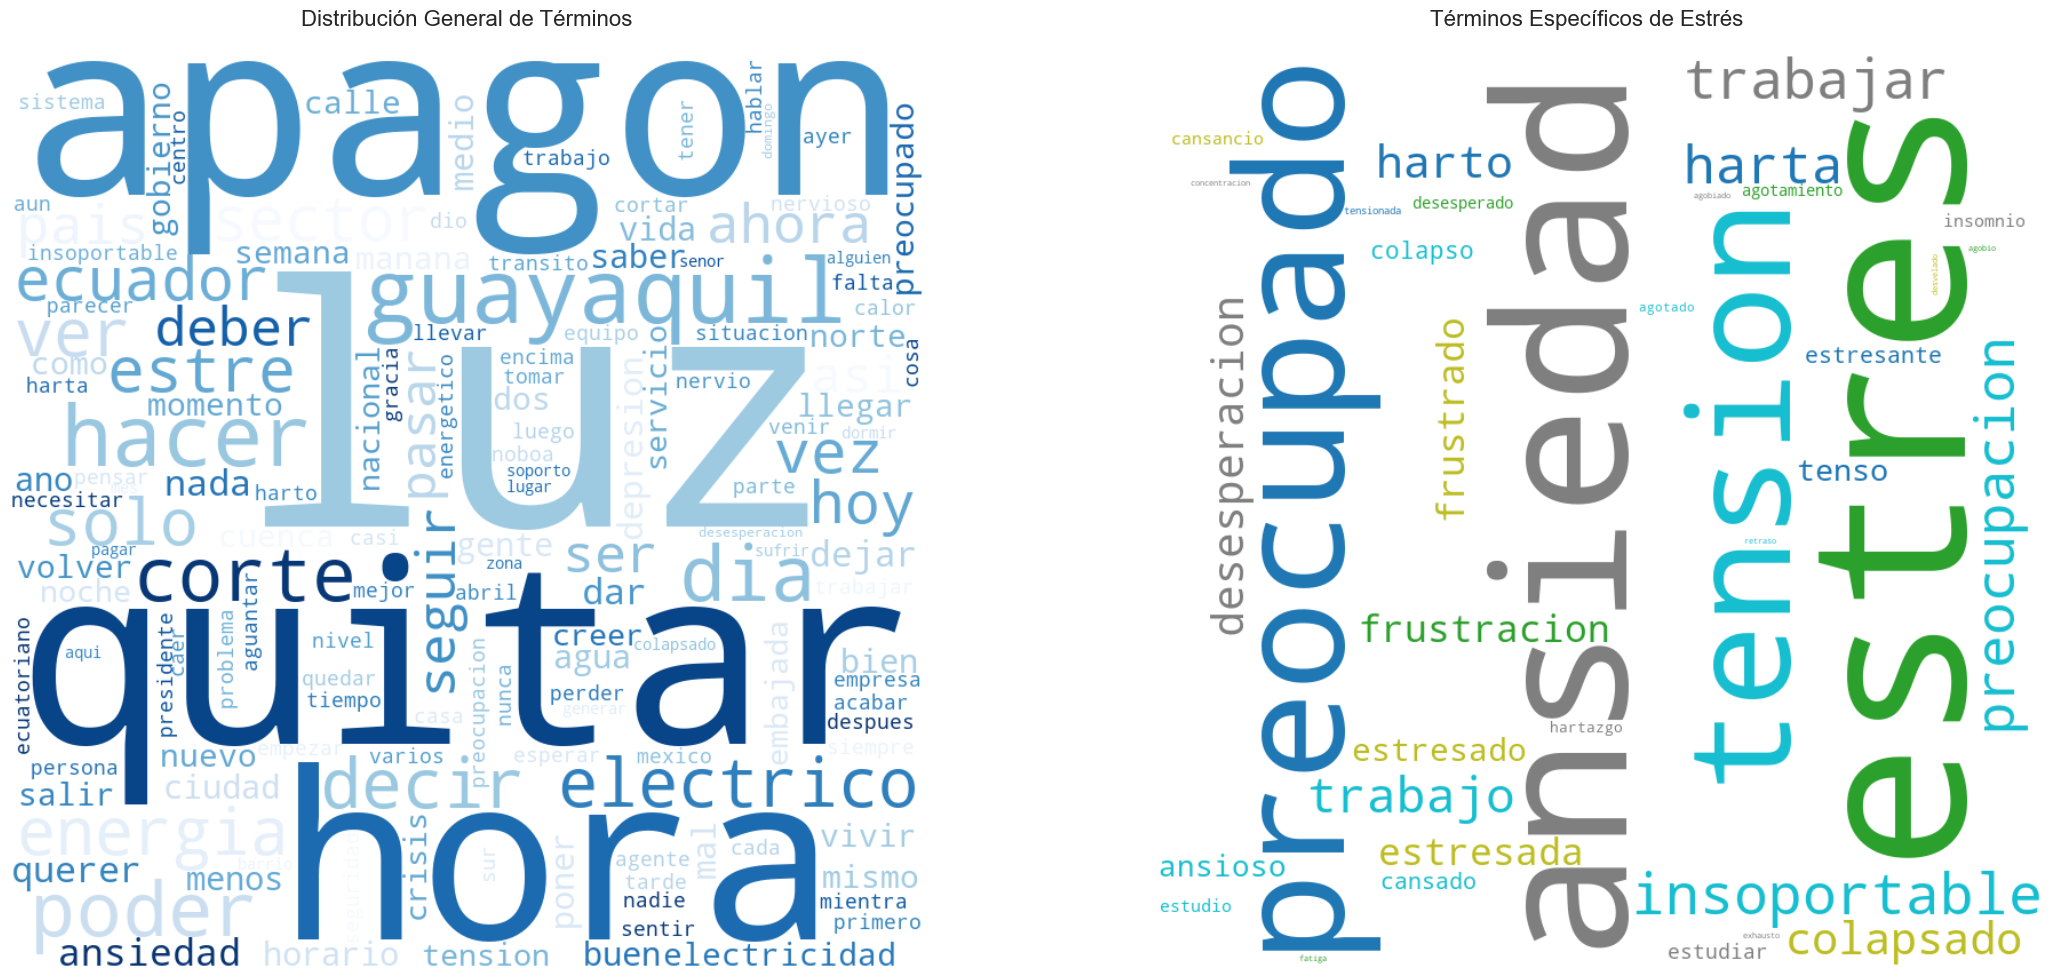


Análisis de Términos de Estrés:
Total de términos de estrés identificados: 1379
Términos únicos de estrés: 37

Top 20 términos de estrés:


,Término,Frecuencia,Porcentaje
0,estres,226,16.388687
1,ansiedad,160,11.602611
2,preocupado,102,7.396664
3,tension,88,6.381436
4,insoportable,84,6.091371
5,trabajar,82,5.946338
6,preocupacion,79,5.728789
7,harta,73,5.293691
8,trabajo,65,4.713561
9,harto,57,4.133430


In [10]:
# Bloque unificado: Visualización comparativa con colores personalizados (sin "quibir")

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import pandas as pd

# Configuración de estilo
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('ggplot')
    
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Definición de términos de estrés (asegurando que no contenga "quibir")
terminos_estres = {
    # Formas básicas
    'estres', 'estresado', 'estresada', 'estresante', 'estresor', 
    'tension', 'tensionado', 'tensionada', 'tenso', 'tensa',
    'agotamiento', 'agotado', 'agotada', 'cansancio', 'cansado', 'cansada',
    'fatiga', 'fatigado', 'fatigada', 'exhausto', 'exhausta',
    
    # Problemas de sueño
    'insomnio', 'desvelo', 'desvelado', 'desvelada', 'dormir mal',
    
    # Estados emocionales
    'ansiedad', 'ansioso', 'ansiosa', 'preocupacion', 'preocupado', 'preocupada',
    'frustracion', 'frustrado', 'frustrada', 'irritacion', 'irritado', 'irritada',
    'desesperacion', 'desesperado', 'desesperada', 'agobio', 'agobiado', 'agobiada',
    
    # Problemas cognitivos
    'concentracion', 'desenfoque', 'desenfocado', 'desenfocada',
    
    # Impacto laboral/académico
    'trabajo', 'trabajar', 'estudio', 'estudiar', 'improductivo', 'improductiva',
    'retraso', 'retrasado', 'retrasada', 'clases', 'trabajo',
    
    # Expresiones coloquiales
    'colapso', 'colapsado', 'colapsada', 'hartazgo', 'harto', 'harta',
    'insoportable', 'no aguanto', 'hasta cuando', 'el colmo'
}

# Aseguramos que "quibir" no esté en los términos de estrés
terminos_estres.discard('quibir')

# Procesamiento de datos CON FILTRO PARA "quibir"
def filtrar_quibir(lista_palabras):
    return [palabra for palabra in lista_palabras if palabra != 'quibir']

# Aplicamos el filtro a todos los lemas
all_lemas = ' '.join([' '.join(filtrar_quibir(lemas)) for lemas in df['tweet_lemma']])

# Filtramos términos de estrés y además excluimos "quibir"
lemas_estres = [lemma for lista_lemas in df['tweet_lemma'] 
                for lemma in filtrar_quibir(lista_lemas) 
                if lemma in terminos_estres]

# Paleta de colores personalizada (azul y verde)
colores_estres = ['#1f77b4', '#2ca02c', '#17becf', '#7f7f7f', '#bcbd22']  # Azules y verdes

# Visualización comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Nube general (azul)
if all_lemas.strip():
    wordcloud_general = WordCloud(
        width=800,
        height=800,
        background_color='white',
        colormap='Blues',
        max_words=150,
        collocations=False
    ).generate(all_lemas)
    
    ax1.imshow(wordcloud_general, interpolation='bilinear')
    ax1.set_title('Distribución General de Términos', pad=20, size=16)
    ax1.axis('off')
else:
    ax1.text(0.5, 0.5, 'No hay datos para visualizar', ha='center', va='center')
    ax1.axis('off')

# Nube de estrés (combinación azul/verde)
if lemas_estres:
    wordcloud_estres = WordCloud(
        width=800,
        height=800,
        background_color='white',
        color_func=lambda *args, **kwargs: colores_estres[len(args[0]) % len(colores_estres)],
        max_words=100,
        collocations=False
    ).generate(' '.join(lemas_estres))
    
    ax2.imshow(wordcloud_estres, interpolation='bilinear')
    ax2.set_title('Términos Específicos de Estrés', pad=20, size=16)
    ax2.axis('off')
else:
    ax2.text(0.5, 0.5, 'No se encontraron términos de estrés', ha='center', va='center')
    ax2.axis('off')

plt.tight_layout()
plt.show()

# Análisis complementario con colores personalizados
if lemas_estres:
    freq_estres = Counter(lemas_estres)
    top_estres = freq_estres.most_common(20)
    
    df_estres = pd.DataFrame(top_estres, columns=['Término', 'Frecuencia'])
    df_estres['Porcentaje'] = (df_estres['Frecuencia'] / len(lemas_estres)) * 100
    
    print("\nAnálisis de Términos de Estrés:")
    print("="*50)
    print(f"Total de términos de estrés identificados: {len(lemas_estres)}")
    print(f"Términos únicos de estrés: {len(freq_estres)}")
    print("\nTop 20 términos de estrés:")
    
    # Aplicamos estilo con gradiente verde
    display(df_estres.style.background_gradient(cmap='Greens', subset=['Frecuencia', 'Porcentaje']))

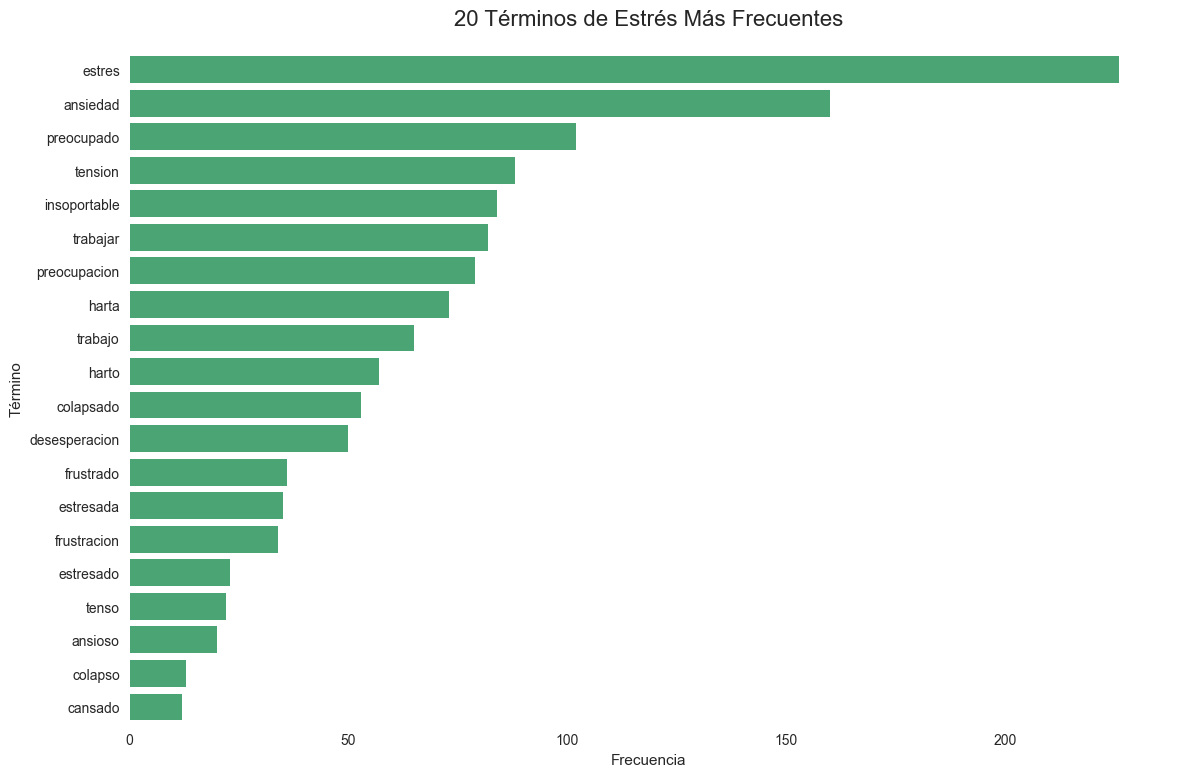

In [11]:
if lemas_estres:
    freq_estres = Counter(lemas_estres)
    top_20 = freq_estres.most_common(20)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x=[count for word, count in top_20],
        y=[word for word, count in top_20],
        color='mediumseagreen' 
    )
    plt.title('20 Términos de Estrés Más Frecuentes', pad=20, size=16)
    plt.xlabel('Frecuencia')
    plt.ylabel('Término')
    plt.tight_layout()
    plt.show()

In [12]:
# Seleccionar las columnas requeridas
columnas_deseadas = ['Tweet_ID', 'Created_At', 'Location_Mentioned', 'Text_Final', 'tweet_lemma']
dataset_lematizado = df[columnas_deseadas].copy()

# Renombrar la columna de lemas para mayor claridad
dataset_lematizado = dataset_lematizado.rename(columns={'tweet_lemma': 'Lemas'})

# Guardar como CSV
dataset_lematizado.to_csv('dataset_lematizado.csv', index=False, encoding='utf-8')
print("Archivo 'dataset_lematizado.csv' guardado correctamente con", len(dataset_lematizado), "registros")

Archivo 'dataset_lematizado.csv' guardado correctamente con 3676 registros


- Clasificación de Tweets por Términos de Estrés

In [13]:
import ast  # Para convertir strings de listas a listas reales

In [14]:
# Cargar el dataset lematizado
df = pd.read_csv('dataset_lematizado.csv')

In [15]:
# Convertir la columna 'Lemas' de string a lista (si es necesario)
if isinstance(df['Lemas'].iloc[0], str):
    df['Lemas'] = df['Lemas'].apply(ast.literal_eval)

# Definición completa de términos de estrés (sinónimos y variantes)
terminos_estres = {
    # Formas básicas
    'estres', 'estresado', 'estresada', 'estresante', 'estresor', 
    'tension', 'tensionado', 'tensionada', 'tenso', 'tensa',
    'agotamiento', 'agotado', 'agotada', 'cansancio', 'cansado', 'cansada',
    'fatiga', 'fatigado', 'fatigada', 'exhausto', 'exhausta',
    
    # Problemas de sueño
    'insomnio', 'desvelo', 'desvelado', 'desvelada', 'dormir mal',
    
    # Estados emocionales
    'ansiedad', 'ansioso', 'ansiosa', 'preocupacion', 'preocupado', 'preocupada',
    'frustracion', 'frustrado', 'frustrada', 'irritacion', 'irritado', 'irritada',
    'desesperacion', 'desesperado', 'desesperada', 'agobio', 'agobiado', 'agobiada',
    
    # Problemas cognitivos
    'concentracion', 'desenfoque', 'desenfocado', 'desenfocada',
    
    # Impacto laboral/académico
    'trabajo', 'trabajar', 'estudio', 'estudiar', 'improductivo', 'improductiva',
    'retraso', 'retrasado', 'retrasada', 'clases', 'trabajo',
    
    # Expresiones coloquiales
    'colapso', 'colapsado', 'colapsada', 'hartazgo', 'harto', 'harta',
    'insoportable', 'aguanto', 'cuando', 'colmo'
}

In [16]:
# Función para clasificar el sentimiento
def clasificar_estres(lemas):
    """
    Devuelve 1 si encuentra términos de estrés, 0 si no
    """
    if any(lemma in terminos_estres for lemma in lemas):
        return 1
    return 0

# Aplicar la clasificación
df['sentimiento'] = df['Lemas'].apply(clasificar_estres)

# Mostrar resultados
print(f"Total tweets: {len(df)}")
print(f"Tweets con estrés: {df['sentimiento'].sum()} ({df['sentimiento'].mean()*100:.2f}%)")

# Mostrar ejemplos
print("\nEjemplos de tweets clasificados como estrés (1):")
display(df[df['sentimiento'] == 1][['Lemas', 'sentimiento']].head())

print("\nEjemplos de tweets clasificados como no estrés (0):")
display(df[df['sentimiento'] == 0][['Lemas', 'sentimiento']].head())

# Guardar el nuevo dataset con la columna de sentimiento
df.to_csv('dataset_clasificado.csv', index=False, encoding='utf-8')
print("\nDataset guardado como 'dataset_clasificado.csv'")


Total tweets: 3676
Tweets con estrés: 1301 (35.39%)

Ejemplos de tweets clasificados como estrés (1):


,Lemas,sentimiento
6,"[asi, complejo, situacion, perder, control, si...",1
20,"[quinto, vez, hora, medio, luz, tratar, trabaj...",1
23,"[harto, nuevo, ecuador, ecuador, encuentro, qu...",1
24,"[harto, vivir, ecuador, siempre, pedir, deber,...",1
28,"[deficit, energetico, pais, ahora, inepto, sol...",1



Ejemplos de tweets clasificados como no estrés (0):


,Lemas,sentimiento
0,"[luz, danar, panel, electronico, elevador, lum...",0
1,"[querer, arrecharme, hdp, corpoelec, quitar, l...",0
2,"[dos, dia, apagon, masivo, dejar, medio, archi...",0
3,"[hora, persona, afectado, apagon, deber, incap...",0
4,"[ideologia, arruinar, red, electrico, ordenar,...",0



Dataset guardado como 'dataset_clasificado.csv'


RESUMEN DE CLASIFICACIÓN POR ESTRÉS


,Categoría,Cantidad,Porcentaje
0,Total tweets,3676,100%
1,Tweets con estrés (1),1301,35.39%
2,Tweets sin estrés (0),2375,64.61%



DISTRIBUCIÓN DE TWEETS POR ESTRÉS
📊 Total de tweets analizados: 3676
🔴 Tweets con estrés (1): 1301 (35.39%)
🟢 Tweets sin estrés (0): 2375 (64.61%)


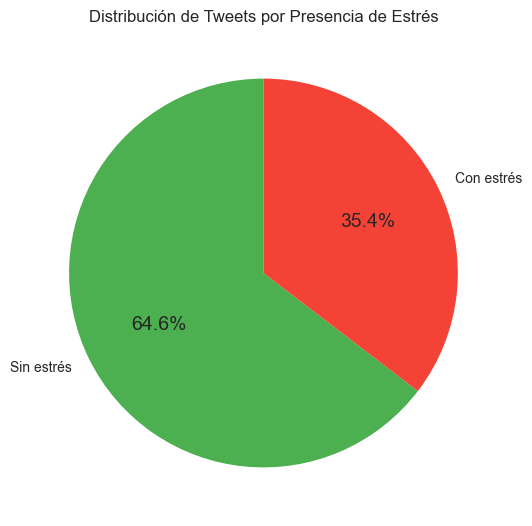

In [17]:
# Cálculo de estadísticas básicas
total_tweets = len(df)
tweets_con_estres = df['sentimiento'].sum()
tweets_sin_estres = total_tweets - tweets_con_estres
porcentaje_con_estres = (tweets_con_estres / total_tweets) * 100
porcentaje_sin_estres = 100 - porcentaje_con_estres

# Crear DataFrame con los resultados
resumen_estres = pd.DataFrame({
    'Categoría': ['Total tweets', 'Tweets con estrés (1)', 'Tweets sin estrés (0)'],
    'Cantidad': [total_tweets, tweets_con_estres, tweets_sin_estres],
    'Porcentaje': ['100%', f'{porcentaje_con_estres:.2f}%', f'{porcentaje_sin_estres:.2f}%']
})

# Mostrar resultados
print("RESUMEN DE CLASIFICACIÓN POR ESTRÉS")
print("="*40)
display(resumen_estres)

# Versión alternativa más visual
print("\nDISTRIBUCIÓN DE TWEETS POR ESTRÉS")
print("="*40)
print(f"📊 Total de tweets analizados: {total_tweets}")
print(f"🔴 Tweets con estrés (1): {tweets_con_estres} ({porcentaje_con_estres:.2f}%)")
print(f"🟢 Tweets sin estrés (0): {tweets_sin_estres} ({porcentaje_sin_estres:.2f}%)")

# Gráfico de distribución simple
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
df['sentimiento'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Sin estrés', 'Con estrés'],
    colors=['#4CAF50', '#F44336'],
    startangle=90
)
plt.title('Distribución de Tweets por Presencia de Estrés')
plt.ylabel('')
plt.show()